 This file contains functions that can be easily used for other parts of the experiment.
 To make new data mods, duplicate this file and add a new function to replace "basic_preprocessing" in this pipeline.

# Read Data

In [10]:
from ipynb.fs.full.create_dataframe import read_data
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from random import choice,sample

In [11]:
def show_images(image_list):
    for i in image_list:
        plt.imshow(i)
        plt.pause(0.5)

def convertToArray(image_list):
    image_array_list=[]
    for i in image_list:
        image_array_list.append(np.asarray(i))
    return pd.Series(image_array_list)

def convertToImage(image_array_list):
    image_list=[]
    for i in image_array_list:
        image_list.append(Image.fromarray(i))
    return pd.Series(image_list)


In [12]:
# create dataframe using other file's code
reptiles=read_data(["Crocodile_Alligator","Gecko"])
reptiles.target.value_counts()

Frog_Toad          500
Turtle_Tortoise    500
Lizard             500
Snake              499
Salamander         466
Name: target, dtype: int64

In [13]:
def basic_preprocess(dataframe):
    # Basic preprocessing 
    dataframe=dataframe[dataframe.astype(str)['image'] != '[]']

    # prepare X
    img_list = list(dataframe['image'])
    data_img = []
    for each in img_list:
                each_img = cv2.cvtColor(each, cv2.COLOR_BGR2RGB)
                #Resize the images:
                each_img_resized = cv2.resize(each_img, (128,128))
                #Save arrays to a list:
                data_img.append(each_img_resized)
    # Converting list to numpy array
    X = np.array(data_img)

    # prepare y
    y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(dataframe['target'].values.reshape(-1,1))

    return X,y


In [15]:
X,y= basic_preprocess(reptiles) ## replace this to change preprocessing

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)


X_train shape:  (1676, 128, 128, 3)
y_train shape:  (1676, 5)
X_val shape  :  (419, 128, 128, 3)
y_val shape  :  (419, 5)
X_test shape :  (370, 128, 128, 3)
y_test shape :  (370, 5)


In [16]:
create_label_key(y,reptiles)

{'Frog_Toad': 0,
 'Turtle_Tortoise': 4,
 'Lizard': 1,
 'Salamander': 2,
 'Snake': 3}

In [17]:
def fit_model(X_train,y_train,X_val):
    #  code adapted from:
    #  https://pub.towardsai.net/multiclass-image-classification-hands-on-with-keras-and-tensoflow-e1cf434f3467


    train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
    validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)
    train_gen.fit(X_train)
    validation_gen.fit(X_val)
    batch_size = 64
    epochs = 10
    base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=(128,128,3))
    x = base.output
    x = GlobalAveragePooling2D()(x)
    head = Dense(y_train.shape[1], activation='softmax')(x)
    model = Model(inputs=base.input, outputs=head)
    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)
    
    fit = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = epochs,
               validation_data = validation_gen.flow(X_val, y_val)
)

    return model,fit

In [18]:
model,fit=fit_model(X_train,y_train,X_val)

/var/folders/5b/sjkc4b8n0hs41zd03hxr66100000gn/T/ipykernel_65054/1677556381.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(


Epoch 1/10
27/27 [==============================] - 172s 6s/step - loss: 1.4875 - accuracy: 0.3496 - val_loss: 1.5024 - val_accuracy: 0.4010
Epoch 2/10
27/27 [==============================] - 249s 9s/step - loss: 1.1241 - accuracy: 0.5859 - val_loss: 1.4743 - val_accuracy: 0.5322
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 0.8886 - accuracy: 0.6862 

In [ ]:
def make_plots(model_fit):
    history_df = pd.DataFrame(model_fit.history)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history_df['loss'], '.', linestyle='solid', label='training loss')
    plt.plot(history_df['val_loss'], '.', linestyle='solid', label='validation loss')
    plt.title('Model Loss Function')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history_df['accuracy'], '.', linestyle='solid', label='training accuracy')
    plt.plot(history_df['val_accuracy'], '.', linestyle='solid', label='validation accuracy')
    plt.title('Model Accuracy')
    plt.legend();

def getPredTestClasses(model, X_test):
    y_pred = model.predict(X_test)
    # Converting prediction classes from one hot encoding to list
    # Argmax returns the position of the largest value
    y_pred_classes = np.argmax(y_pred, axis = 1)
    # Convert test labels from one hot encoding to list
    y_test_classes = np.argmax(y_test, axis = 1)
    return y_test_classes,y_pred_classes

def make_conf_matrix(y_test_classes,y_pred_classes):
    # Create the confusion matrix
    confmx = confusion_matrix(y_test_classes, y_pred_classes)
    f, ax = plt.subplots(figsize = (8,8))
    sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show();

make_plots(fit)
y_test_classes,y_pred_classes= getPredTestClasses(model, X_test)
make_conf_matrix(y_test_classes,y_pred_classes)

In [ ]:
def create_label_key(y,data):
    dic={}
    for s in np.arange(0, len(reptiles), 520, dtype=int):
        key=data["target"][s]
        key_value=np.where(y[s] == 1)[0][0]
        dic[key]=key_value
    return dic

predicted=pd.DataFrame({"True":y_test_classes,"Pred":y_pred_classes})

# change classes to actual labels
label_key = create_label_key(y,reptiles)
predicted=predicted.replace({"True": label_key,"Pred":label_key})

In [ ]:
def show_sample_misclassified(predicted):
    misclassified=predicted.loc[~(predicted['True'] == predicted['Pred'])]
    indices = sample(misclassified.index.to_list(),8)
    i = 1
    plt.figure(figsize=(14,7))
    for each in indices:
        plt.subplot(2,4,i)
        plt.imshow(Image.fromarray(X_test[each]))
        plt.title("True:"+misclassified['True'].loc[each]+"\nPredicted: "+misclassified['Pred'].loc[each])
        plt.xticks([])
        plt.yticks([])
        i += 1

show_sample_misclassified(predicted)

TypeError: can only concatenate str (not "numpy.int64") to str

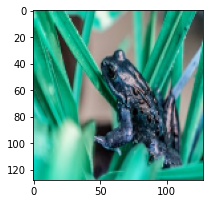

# Changing Aperture

In [ ]:
def circle(matrix, radius):
  height = len(matrix[0])
  width = len(matrix[0][0])

  for row in range(height):
    for col in range(width):
      if (height/2 - row)**2 + (width/2 - col)**2 < radius**2:
        matrix[0,row,col] = 1
  return matrix

In [ ]:
class TransformAperture(tf.keras.layers.Layer):
  def __init__(self):
    super(TransformAperture, self).__init__()
    self.circ_aper = tf.Variable(circle(np.zeros((1,128,128,1)), 50), dtype=tf.dtypes.float32, name='aperture')
    # self.aper_phase = tf.Variable(tf.cast(np.full((128,128, 1), 0.5), tf.dtypes.float32), name='aperture_phase')

  def call(self, input):
    image = tf.cast(input, tf.dtypes.complex64)
    image = tf.signal.fftshift(tf.signal.fft2d(image))
    image = image * tf.exp(1j*tf.cast(self.circ_aper, tf.dtypes.complex64))
    # image = image * tf.exp(1j*tf.cast(self.aper_phase, tf.dtypes.complex64))
    image = tf.signal.ifft2d(tf.signal.ifftshift(image))
    image = tf.abs(image)**2
    # plt.imshow(image)
    return tf.cast(image, tf.dtypes.float32)

In [ ]:
aperture = physical_layer()
img = Image.open("/content/drive/MyDrive/Colab_Notebooks/BME 548/bme-reptile-identification/data/reptiles/Lizard/10573142086_4f1398c293_o.jpg")
img = np.array(img)/255
img = cv2.resize(img, (128,128))
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.title('Lizard')
img = aperture.call(img)
img = np.array(img).reshape(128,128,3)
plt.figure()
plt.title('Lizard with Aperture = 50%')
plt.imshow(img)
plt.axis('off')

NameError: name 'physical_layer' is not defined

In [ ]:
def transform_image(image_list):
    transformed = []
    for i in range(image_list.shape[0]):
        aperture = TransformAperture()
        img = np.array(image_list[i])/255
        img = cv2.resize(img, (128,128))
        img = aperture.call(img)
        img = np.array(img).reshape(128,128,3)
        transformed.append(img)
        if i % 500 == 0:
            print(f"Transformed {i} images.")
    image_data = np.array(transformed)
    return image_data


In [ ]:
X_train_transformed = transform_image(X_train)

Transformed 0 images.
Transformed 500 images.
Transformed 1000 images.
Transformed 1500 images.
Transformed 2000 images.


In [ ]:
X_val_transformed = transform_image(X_val)

Transformed 0 images.
Transformed 500 images.


In [ ]:
X_test_transformed = transform_image(X_test)

Transformed 0 images.
Transformed 500 images.


# Train and Test model with transformed Data

In [ ]:
model_transformed, fit_transformed = fit_model(X_train_transformed, y_train, X_val_transformed)

<ipython-input-10-f17f73c0c6cd>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(


Epoch 1/10
39/39 [==============================] - 38s 393ms/step - loss: 1.9449 - accuracy: 0.2622 - val_loss: 1.6580 - val_accuracy: 0.4042
Epoch 2/10
39/39 [==============================] - 15s 387ms/step - loss: 1.5375 - accuracy: 0.4654 - val_loss: 1.3050 - val_accuracy: 0.5406
Epoch 3/10
39/39 [==============================] - 15s 389ms/step - loss: 1.2146 - accuracy: 0.5870 - val_loss: 1.1957 - val_accuracy: 0.6185
Epoch 4/10
39/39 [==============================] - 16s 398ms/step - loss: 0.9977 - accuracy: 0.6598 - val_loss: 1.1255 - val_accuracy: 0.6364
Epoch 5/10
39/39 [==============================] - 15s 387ms/step - loss: 0.8777 - accuracy: 0.7150 - val_loss: 0.9691 - val_accuracy: 0.6948
Epoch 6/10
39/39 [==============================] - 15s 387ms/step - loss: 0.8020 - accuracy: 0.7260 - val_loss: 0.9880 - val_accuracy: 0.6721
Epoch 7/10
39/39 [==============================] - 16s 394ms/step - loss: 0.7489 - accuracy: 0.7390 - val_loss: 0.8702 - val_accuracy: 0.7224

17/17 [==============================] - 1s 86ms/step


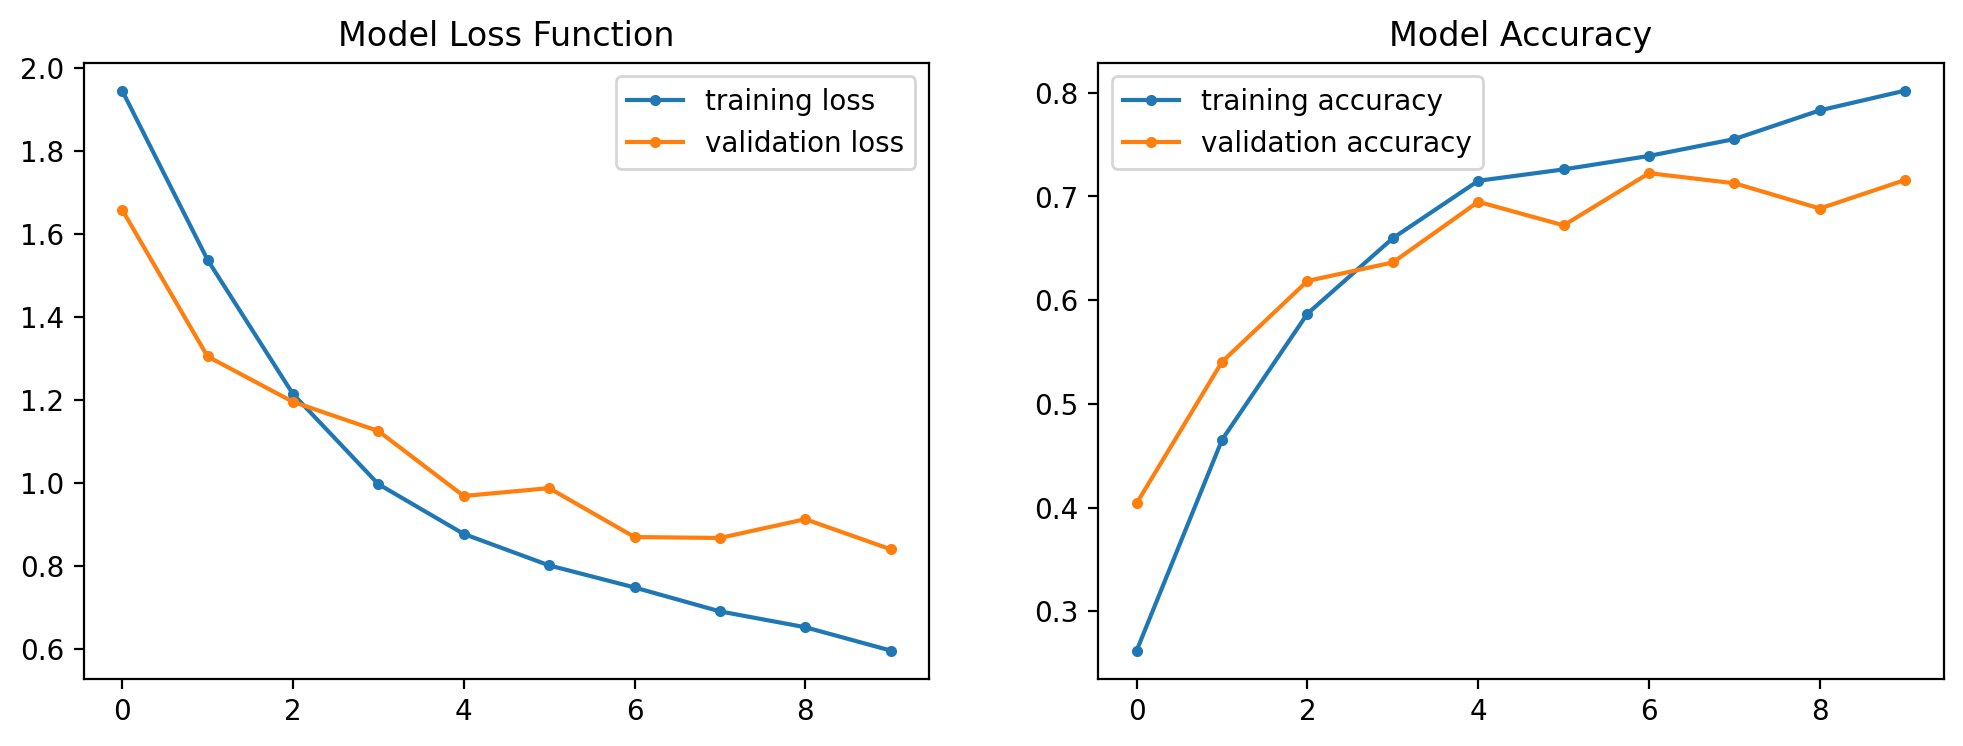

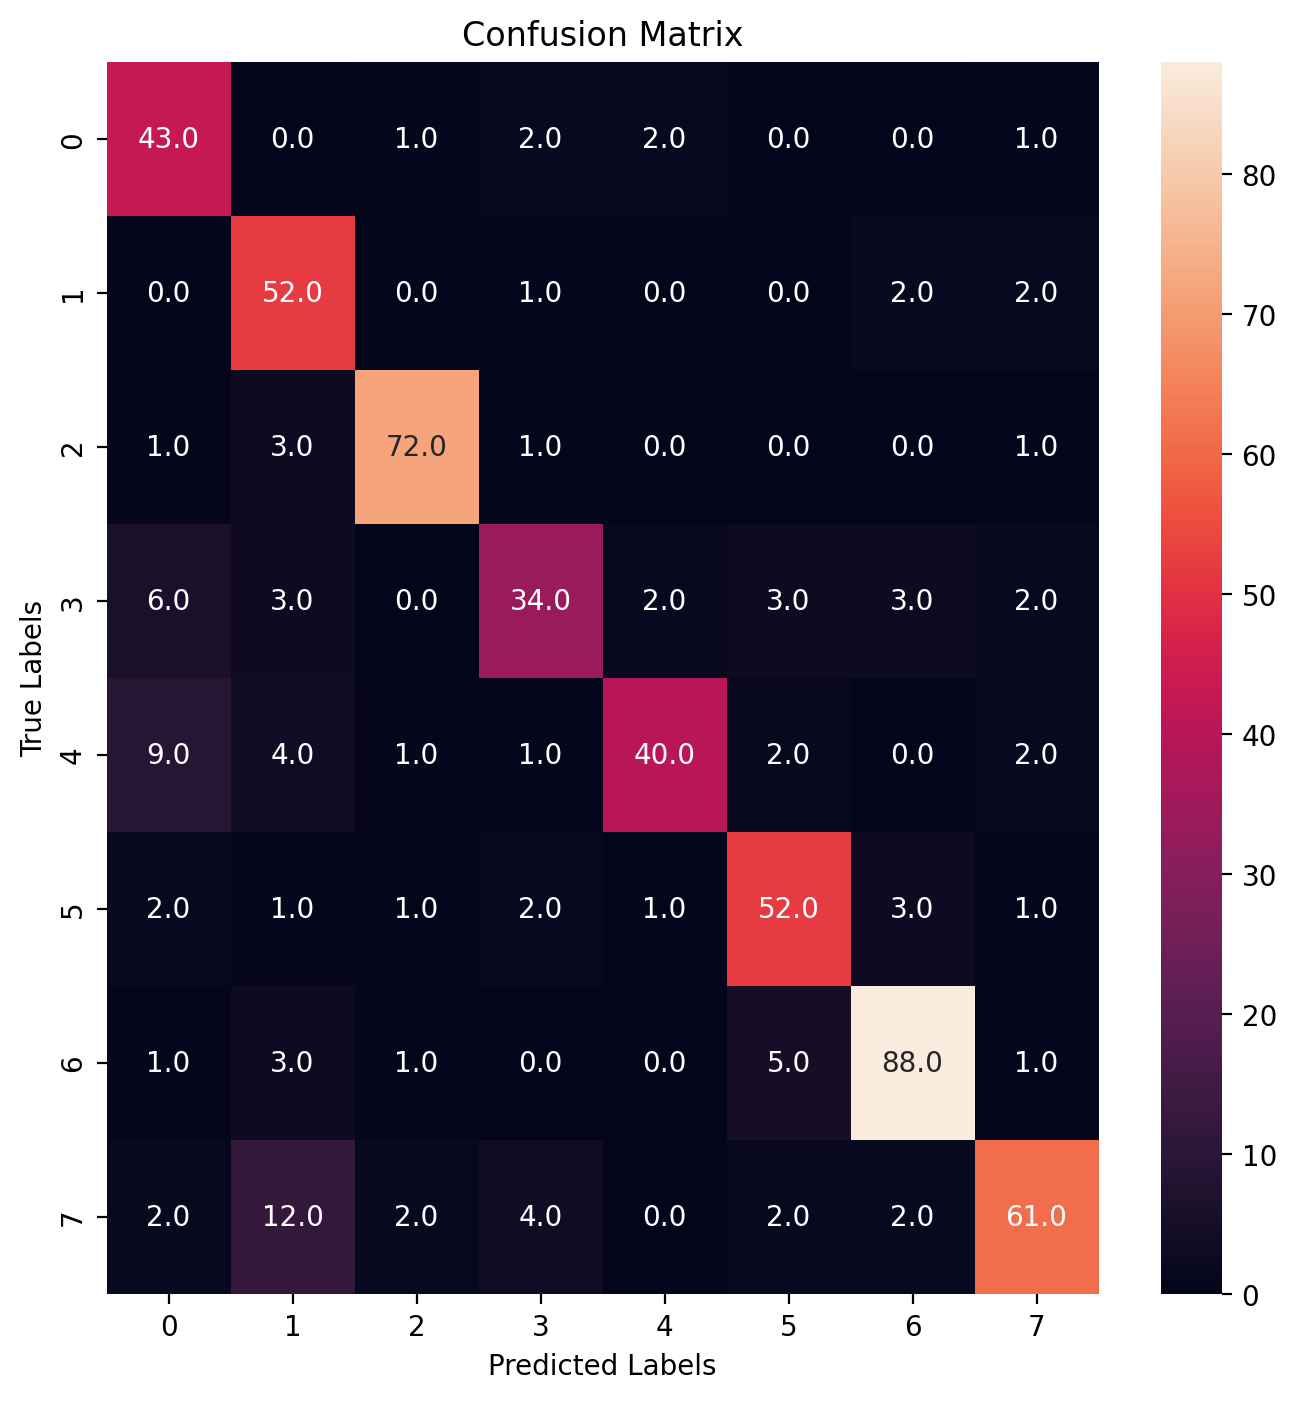

In [ ]:
make_plots(fit_transformed)

y_test_classes, y_pred_classes = getPredTestClasses(model_transformed, X_test_transformed)
make_conf_matrix(y_test_classes, y_pred_classes)
